In [19]:
%matplotlib qt
import numpy as np
import os
import pycs3.gen.lc_func
import pycs3.gen.splml
import pycs3.gen.mrg
import pycs3.spl.topopt
import pycs3.regdiff.multiopt
import pycs3.regdiff.rslc
import pycs3.gen.util
import pycs3.sim.draw
import pycs3.sim.run
import pycs3.sim.plot
import pycs3.sim.twk
import pycs3.tdcomb.plot
import pycs3.tdcomb.comb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl
import logging
loggerformat='%(message)s'
logging.basicConfig(format=loggerformat,level=logging.INFO)

# plt.rcParams.update({'text.usetex': True})


In [4]:
rdbfile = '../data/RXJ1131_Tewes2013.txt'
rxj1131_lcs = [
        pycs3.gen.lc_func.rdbimport(rdbfile, object='A', magcolname='mag_A', magerrcolname='magerr_A', telescopename='RXJ1131'),
        pycs3.gen.lc_func.rdbimport(rdbfile, object='B', magcolname='mag_B', magerrcolname='magerr_B', telescopename='RXJ1131'),
        pycs3.gen.lc_func.rdbimport(rdbfile, object='C', magcolname='mag_C', magerrcolname='magerr_C', telescopename='RXJ1131'),
        pycs3.gen.lc_func.rdbimport(rdbfile, object='D', magcolname='mag_D', magerrcolname='magerr_D', telescopename='RXJ1131')
]

# pycs3.gen.util.multilcsexport(rxj1131_lcs, separator='\t', filepath='../../rxj1131_pipeline/data/RXJ1131_dataset.rdb', rdbunderline=True)

Checking header of "RXJ1131_Tewes2013.txt"...
Reading "RXJ1131_Tewes2013.txt"...
[RXJ1131/A] with 707 points imported (0 of them masked).
Checking header of "RXJ1131_Tewes2013.txt"...
Reading "RXJ1131_Tewes2013.txt"...
[RXJ1131/B] with 707 points imported (0 of them masked).
Checking header of "RXJ1131_Tewes2013.txt"...
Reading "RXJ1131_Tewes2013.txt"...
[RXJ1131/C] with 707 points imported (0 of them masked).
Checking header of "RXJ1131_Tewes2013.txt"...
Reading "RXJ1131_Tewes2013.txt"...
[RXJ1131/D] with 707 points imported (0 of them masked).


In [7]:
# Display info and unshifted light curves
print(rxj1131_lcs[0].longinfo())
pycs3.gen.mrg.colourise(rxj1131_lcs)

# reset timeshifts previously applied
for lc in rxj1131_lcs:  
    lc.resetshifts()
    
pycs3.gen.lc_func.display(rxj1131_lcs, figsize=(19/1.6,10/1.6), nicefont=True, showdates=True, showgrid=True, markersize=4, title=r'$\mathrm{RX\ J1131-1231}$', filename='../figures/rxj1131_lcdata.png')

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
	[RXJ1131/A]
707 points (total), 0 of which are masked
9 seasons (gap: >60), gap length : 132.1 +/- 12.5 days
Sampling : median 2.0, mean 2.9, max 26.9, min 0.00 days
Shifts : (0.00000,0.00000,0.00) [days, mag, flux]
Colour : red
Common properties : airmass, fwhm, nbimg, normcoeff, telescope
   All properties : airmass, fwhm, nbimg, normcoeff, telescope
Comments :
   Imported from RXJ1131_Tewes2013.txt, columns (1, 2, 3)
   Timeshift optimized with regdiff.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


Plot written to ../figures/rxj1131_lcdata.png


## Spline method

Optimising function, `opt_fine` assumes no more than 10d initial delay from true value

In [59]:
# Spline optimization
def spl(lcs):
    # opt_fine: supposes that lcs are within 10 days of true delays
    spline = pycs3.spl.topopt.opt_rough(lcs, nit=5, knotstep=30, verbose=False)
    spline = pycs3.spl.topopt.opt_fine(lcs, nit=5, knotstep=20, verbose=False)
    return spline

### Spline fit, without microlensing. 
Add initial guess if not using `opt_rough`

In [77]:
# Spline fit 
        
# reset timeshifts previously applied
for lc in rxj1131_lcs:  
    lc.resetshifts()    
    
# We apply initial timeshift guesses
pycs3.gen.lc_func.applyshifts(rxj1131_lcs, [0,0,0,-90], [0,0,0,0])

spline = spl(rxj1131_lcs)
pycs3.gen.lc_func.display(rxj1131_lcs, [spline], figsize=(19/1.6,10/1.6), showdelays=True, showlegend=False,title=r'$\mathrm{Free-knot\ Splines}$', filename='../figures/rxj1131_splineoptnoml.png')

print('Time delays:')
print(pycs3.gen.lc_func.getnicetimedelays(rxj1131_lcs, separator='\n', to_be_sorted=True))

Starting ML optimization ...
Done !
Plot written to ../figures/rxj1131_splineoptnoml.png


Time delays:
AB =  +20.30
AC =  +19.20
AD = -103.26
BC =   -1.09
BD = -123.55
CD = -122.46


### Spline fit, with added spline to model microlensing
Play with `mlknotstep` for initial knot spacing of ml spline

In [76]:
# Spline microlensing

# reset timeshifts previously applied
for lc in rxj1131_lcs:  
    lc.resetshifts()
    
mlknotstep = 150   # initial ml knotstep

# We apply initial timeshift guesses
pycs3.gen.lc_func.applyshifts(rxj1131_lcs, [0,0,0,-90], [0,0,0,0])

# attach microlensing splines to lcs B, C, D
for lc in rxj1131_lcs[1:] : 
    pycs3.gen.splml.addtolc(lc, knotstep=mlknotstep) #we attach microlensing to the LightCurve object
    
    
spline = spl(rxj1131_lcs)
pycs3.gen.lc_func.display(rxj1131_lcs, [spline], figsize = (19/1.6,10/1.6), showdelays=True,
                         showlegend=False, title=r'$\mathrm{Free-knot\ Splines\ with\ ML}$', collapseref=True, filename='../figures/rxj1131_splineoptml.png')
print("Time delays:")
print(pycs3.gen.lc_func.getnicetimedelays(rxj1131_lcs, separator='\n', to_be_sorted=True))

Starting ML optimization ...
Working on the spline ML of [RXJ1131/B](0.000,-0.455,0)|~3/u/19~|
Working on the spline ML of [RXJ1131/C](0.000,-1.525,0)|~3/u/19~|
Working on the spline ML of [RXJ1131/D](-90.000,-2.618,0)|~3/u/19~|
Done !
Plot written to ../figures/rxj1131_splineoptml.png


Time delays:
AB =   -0.96
AC =   -1.27
AD =  -93.49
BC =   -0.31
BD =  -92.52
CD =  -92.21


## Gaussian process method
GP regression by random sampling of light curves. Available kernels : `matern`, `RBF`, `RatQuad`

C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("T

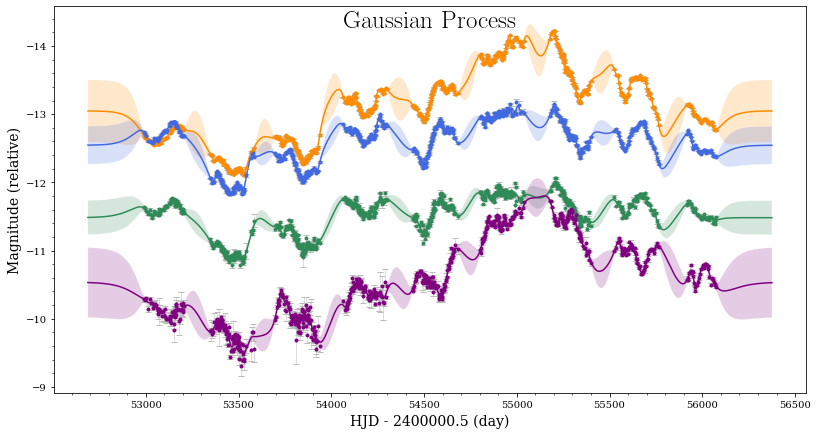

In [8]:
# Gaussian process fit
            
# reset timeshifts previously applied
for lc in rxj1131_lcs:  
    lc.resetshifts()
    
kwargs_reg = {'pd': 2, 'covkernel': 'matern', 'pow': 1.5, 'amp': 1., 'scale': 200., 'errscale': 1, 'verbose': True, 'method': 'weights'}

rslcs = [pycs3.regdiff.rslc.factory(l, pd=kwargs_reg['pd'], covkernel=kwargs_reg['covkernel'], 
                                    pow=kwargs_reg['pow'], errscale=kwargs_reg['errscale']) for l in rxj1131_lcs]

pycs3.gen.lc_func.display(rxj1131_lcs, rslcs, figsize=(19/1.6,10/1.6), title=r'$\mathrm{Gaussian\ Process}$', showlegend=False)#, filename='../figures/rxj1131_gp.png')

### Regdiff optimization
Minimize residuals of lc substraction to obtain time delay measure

C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("T

Time delays:
AB =   +0.50
AC =   +0.00
AD =  -91.72
BC =   -0.50
BD =  -92.22
CD =  -91.72


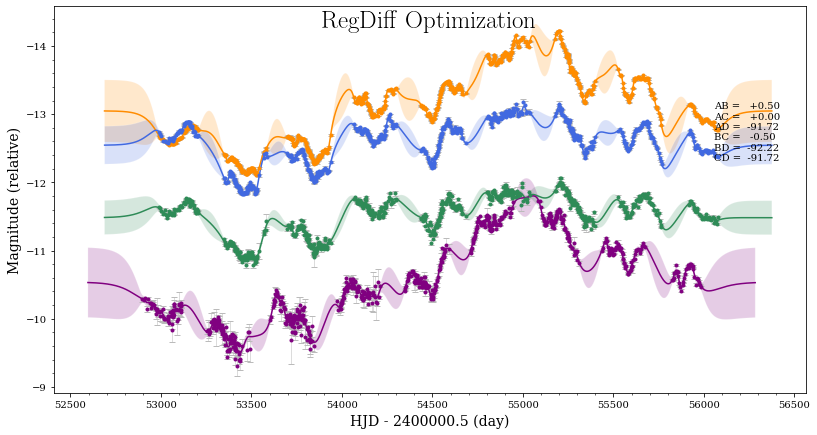

In [9]:
# Regdiff optimization

# Optimization function
def regdiff(lcs, **kwargs):
    return pycs3.regdiff.multiopt.opt_ts(lcs, pd=kwargs['pd'], covkernel=kwargs['covkernel'], pow=kwargs['pow'],
                                        errscale=kwargs['errscale'], verbose=False, method='weights')

# reset timeshifts previously applied
for lc in rxj1131_lcs:  
    lc.resetshifts()
#                                          timeshift           magshift
pycs3.gen.lc_func.applyshifts(rxj1131_lcs, [0., 0, 0, -90.], [0.,0.,0.,0.])  

rslcs, error_fct = regdiff(rxj1131_lcs, pd=2, covkernel='matern', pow=1.5,errscale=1)
print("Time delays:")
print(pycs3.gen.lc_func.getnicetimedelays(rxj1131_lcs, separator='\n', to_be_sorted=True))
pycs3.gen.lc_func.display(rxj1131_lcs, rslcs, figsize=(19/1.6,10/1.6), title=r'$\mathrm{RegDiff\ Optimization}$', showlegend=False, showdelays=True)#, filename='../figures/rxj1131_gp.png')

Display interpolated, shifted curves and residuals

In [23]:
# Light curves already timeshifted
rslcs = [pycs3.regdiff.rslc.factory(l, pd=kwargs_reg['pd'], covkernel=kwargs_reg['covkernel'],
                                   pow=kwargs_reg['pow'], amp=kwargs_reg['amp'], scale=kwargs_reg['scale'], errscale=kwargs_reg['errscale']) for l in rxj1131_lcs]

rslcs_residuals = [pycs3.regdiff.rslc.subtract(rslcs[0],rslcs[i]) for i in [1,2,3]]

# Figure panel
fig1 = plt.figure(figsize=(19/1.2,10/1.2))
gs1 = gridspec.GridSpec(11,2)
gs1.update(left=0.08, right=0.96, top=0.98, bottom=0.05, wspace=0.05, hspace=0.09)
ax1 = plt.subplot(gs1[:8, :])
ax2 = plt.subplot(gs1[8:9, :], sharex=ax1)
ax3 = plt.subplot(gs1[9:10, :], sharex=ax1)
ax4 = plt.subplot(gs1[10:11, :], sharex=ax1)

# colorize residuals curves
for j, lc in enumerate(rslcs_residuals):
    lc.plotcolour = rxj1131_lcs[j+1].plotcolour
    
# prepare legend for different curves
disptext = []
for j, lc in enumerate(rslcs_residuals):
    ycoord = 0.5
    xcoord = 0.03
    kwargs = {'fontsize': 14, 'color': rxj1131_lcs[j+1].plotcolour}
    txt = f'A - {rxj1131_lcs[j+1].object}'
    disptext.append((xcoord, ycoord, txt, kwargs))

pycs3.gen.lc_func.getnicetimedelays(rxj1131_lcs, separator='\n', to_be_sorted=True)
    
# plot light curves, regressions, and differences curves
pycs3.gen.lc_func.display(rxj1131_lcs, rslcs, showdelays=False, showlegend=False,
                         title=r'$\mathrm{RegDiff\ Optimization}$', filename='screen', ax=ax1, style='cosmograil_dr1')
pycs3.gen.lc_func.display([], [rslcs_residuals[0]], showdelays=False, showlegend=False, filename='screen', ax=ax2, style='cosmograil_dr1', text=[disptext[0]])
pycs3.gen.lc_func.display([], [rslcs_residuals[1]], showdelays=False, showlegend=False, filename='screen', ax=ax3, style='cosmograil_dr1', text=[disptext[1]])
pycs3.gen.lc_func.display([], [rslcs_residuals[2]], showdelays=False, showlegend=False, filename='screen', ax=ax4, style='cosmograil_dr1', text=[disptext[2]])

ax1.annotate(pycs3.gen.lc_func.getnicetimedelays(rxj1131_lcs, separator='\n', to_be_sorted=True), (55750,-13.5))

# adjust the axis
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.set_ylabel(f'$m_{rxj1131_lcs[0].object[0]} - m_{rxj1131_lcs[1].object[-1]}$ \n $\mathrm{{(mag)}}$', fontsize=12)
ax3.get_xaxis().set_visible(False)
ax3.set_ylabel(f'$m_{rxj1131_lcs[0].object[0]} - m_{rxj1131_lcs[2].object[-1]}$ \n $\mathrm{{(mag)}}$', fontsize=12)
ax4.set_ylabel('Regression Difference \n Residuals (mag)', fontsize=9)
ax4.set_ylabel(f'$m_{rxj1131_lcs[0].object[0]} - m_{rxj1131_lcs[3].object[-1]}$ \n $\mathrm{{(mag)}}$', fontsize=12)
# plt.tight_layout()
plt.savefig('../figures/rxj1131_regdiff.svg', format='svg', dpi=1200)

C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\Charles\miniconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("T

In [ ]:
# Save optimized curves in pickle file
pycs3.gen.util.writepickle([rxj1131_lcs, rslcs], "../data/optcurves.pkl")

In [ ]:
# Drawing copies
simfolder="../data/sim"

if not os.path.isdir(simfolder):
    os.mkdir(simfolder)
    
lcs, rslcs = pycs3.gen.util.readpickle("../data/optcurves.pkl")
pycs3.sim.draw.multidraw(lcs, onlycopy=True, n=10, npkl=2, simset='copies', destpath=simfolder)

In [ ]:
kwargs_opt_reg = {'pd': 2, 'covkernel': 'matern', 'pow': 1.5, 'amp': 1, 'scale': 200, 'errscale': 1}

success_dic = pycs3.sim.run.multirun('copies', lcs, regdiff, kwargs_opt_reg, optset='reg', tsrand=10.0, keepopt=True, destpath=simfolder)

In [ ]:
dataresults = [
    pycs3.sim.run.collect(directory=os.path.join(simfolder, 'sims_copies_opt_reg'), plotcolour='red', name='Regression difference technique')
]

pycs3.sim.plot.hists(dataresults, r=5.0, nbins=100, showqs=False, dataout=True, usemedian=True, outdir=simfolder)

In [ ]:
# Mock light curve generation
